# CGAN on MNIST data
    Name - Kuldeep Singh
    Roll # - 16235
    BSMS 2016, Physics major

In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization
from tensorflow.keras.layers import Input, Flatten, Embedding, multiply, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers

[[[-0.0365072   0.02251352]
  [-0.03136935 -0.03137647]
  [-0.03651578 -0.03470508]
  [-0.00879878 -0.02225896]
  [-0.03785113 -0.00749563]
  [ 0.02043313  0.02115119]
  [-0.0497095   0.03978694]
  [ 0.01848385  0.00020313]
  [-0.01367126 -0.04335881]
  [-0.00138942  0.02739788]]]


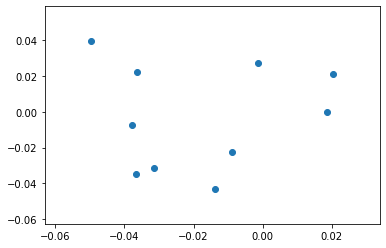

In [3]:
model = Sequential()
model.add(Embedding(10, 2))
# the model will take as input an integer matrix of size (batch, input_length).

# input_array = np.random.randint(10, size=(1, 10))
input_array = np.arange(0, 10).reshape(1, -1)
model.compile('rmsprop', 'mse')
output_array = model.predict(input_array)
print(output_array)
# print(output_array.shape)
plt.scatter(output_array[0, :, 0], output_array[0, :, 1])

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

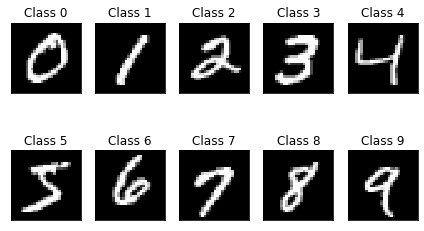

In [5]:
fig = plt.figure()
for i in range(10):
    plt.subplot(2, 5, i+1)
    x_y = X_train[y_train == i]
    plt.imshow(x_y[0], cmap='gray', interpolation='none')
    plt.title("Class %d" % (i))
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()

In [6]:
print('X_train.shape', X_train.shape)
print('y_train.shape', y_train.shape)

# reshaping the inputs
X_train = X_train.reshape(60000, 28*28)
# normalizing the inputs (-1, 1)
X_train = (X_train.astype('float32') / 255 - 0.5) * 2

print('X_train reshape:', X_train.shape)

X_train.shape (60000, 28, 28)
y_train.shape (60000,)
X_train reshape: (60000, 784)


## Defining Generator

In [7]:
# latent space dimension
latent_dim = 100

# imagem dimension 28x28
img_dim = 784

init = initializers.RandomNormal(stddev=0.02)

# Generator network
generator = Sequential()

# Input layer and hidden layer 1
generator.add(Dense(128, input_shape=(latent_dim,), kernel_initializer=init))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))

# Hidden layer 2
generator.add(Dense(256))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))

# Hidden layer 3
generator.add(Dense(512))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))

# Output layer 
generator.add(Dense(img_dim, activation='tanh'))

**Generator Visualization**

In [8]:
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               12928     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 512)              

**Conditional G Model**

In [9]:
# Embedding condition in input layer
num_classes = 10

# Create label embeddings
label = Input(shape=(1,), dtype='int32')
label_embedding = Embedding(num_classes, latent_dim)(label)
label_embedding = Flatten()(label_embedding)

# latent space
z = Input(shape=(latent_dim,))

# Merge inputs (z x label)
input_generator = multiply([z, label_embedding])

# Output image
img = generator(input_generator)

# Generator with condition input
generator = Model([z, label], img)

In [10]:
generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 100)       1000        input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 100)          0           embedding_1[0][0]                
______________________________________________________________________________________________

## Discriminator

In [11]:
discriminator = Sequential()

# Input layer and hidden layer 1
discriminator.add(Dense(128, input_shape=(img_dim,), kernel_initializer=init))
discriminator.add(LeakyReLU(alpha=0.2))

# Hidden layer 2
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(alpha=0.2))

# Hidden layer 3
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(alpha=0.2))

# Output layer
discriminator.add(Dense(1, activation='sigmoid'))

In [12]:
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               100480    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               33024     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

**Conditional D model**

In [13]:
# Embedding condition in input layer

# Create ``label embeddings
label_d = Input(shape=(1,), dtype='int32')
label_embedding_d = Embedding(num_classes, img_dim)(label_d)
label_embedding_d = Flatten()(label_embedding_d)

# imagem dimension 28x28
img_d = Input(shape=(img_dim,))

# Merge inputs (img x label)
input_discriminator = multiply([img_d, label_embedding_d])

# Output image
validity = discriminator(input_discriminator)

# Discriminator with condition input
discriminator = Model([img_d, label_d], validity)

In [14]:
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 784)       7840        input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 784)          0           embedding_2[0][0]                
____________________________________________________________________________________________

**Compile Discriminator**

In [15]:
# Optimizer
optimizer = Adam(lr=0.0002, beta_1=0.5)

discriminator.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

## Compiling Model

In [16]:
discriminator.trainable = False

validity = discriminator([generator([z, label]), label])

d_g = Model([z, label], validity)

d_g.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_2:0


In [17]:
d_g.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 784)          584312      input_2[0][0]                    
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 1)            273441      model[1][0]                

## Fit Model

In [1]:
import time

epoch = 1/100, d_loss=0.675, g_loss=0.914.675, g_loss=0.914


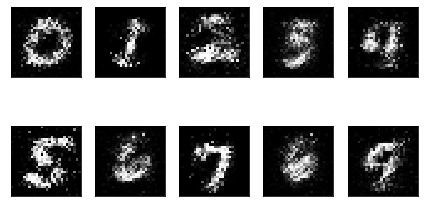

epoch = 2/100, d_loss=0.657, g_loss=0.870.657, g_loss=0.870
epoch = 3/100, d_loss=0.671, g_loss=0.821.671, g_loss=0.821
epoch = 4/100, d_loss=0.673, g_loss=0.825.673, g_loss=0.825
epoch = 5/100, d_loss=0.670, g_loss=0.790.670, g_loss=0.790
epoch = 6/100, d_loss=0.680, g_loss=0.793.680, g_loss=0.793
epoch = 7/100, d_loss=0.681, g_loss=0.820.681, g_loss=0.820
epoch = 8/100, d_loss=0.653, g_loss=0.860.653, g_loss=0.860
epoch = 9/100, d_loss=0.659, g_loss=0.889.659, g_loss=0.889
epoch = 10/100, d_loss=0.673, g_loss=0.915.673, g_loss=0.915
epoch = 11/100, d_loss=0.614, g_loss=0.931.614, g_loss=0.931


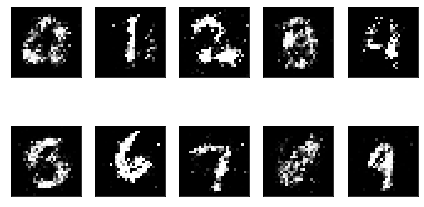

epoch = 12/100, d_loss=0.618, g_loss=0.933.618, g_loss=0.933
epoch = 13/100, d_loss=0.634, g_loss=0.860.634, g_loss=0.860
epoch = 14/100, d_loss=0.628, g_loss=0.922.628, g_loss=0.922
epoch = 15/100, d_loss=0.679, g_loss=0.976.679, g_loss=0.976
epoch = 16/100, d_loss=0.631, g_loss=0.937.631, g_loss=0.937
epoch = 17/100, d_loss=0.586, g_loss=0.964.586, g_loss=0.964
epoch = 18/100, d_loss=0.600, g_loss=1.026.600, g_loss=1.026
epoch = 19/100, d_loss=0.646, g_loss=0.979.646, g_loss=0.979
epoch = 20/100, d_loss=0.641, g_loss=0.914.641, g_loss=0.914
epoch = 21/100, d_loss=0.608, g_loss=0.965.608, g_loss=0.965


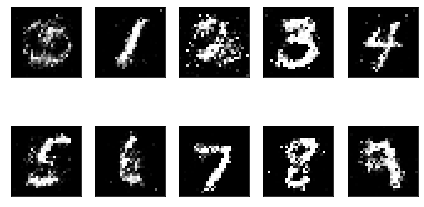

epoch = 22/100, d_loss=0.666, g_loss=0.849.666, g_loss=0.849
epoch = 23/100, d_loss=0.667, g_loss=0.986.667, g_loss=0.986
epoch = 24/100, d_loss=0.649, g_loss=0.976.649, g_loss=0.976
epoch = 25/100, d_loss=0.626, g_loss=0.948.626, g_loss=0.948
epoch = 26/100, d_loss=0.616, g_loss=1.011.616, g_loss=1.011
epoch = 27/100, d_loss=0.609, g_loss=1.000.609, g_loss=1.000
epoch = 28/100, d_loss=0.621, g_loss=0.966.621, g_loss=0.966
epoch = 29/100, d_loss=0.639, g_loss=1.010.639, g_loss=1.010
epoch = 30/100, d_loss=0.607, g_loss=0.961.607, g_loss=0.961
epoch = 31/100, d_loss=0.616, g_loss=0.973.616, g_loss=0.973


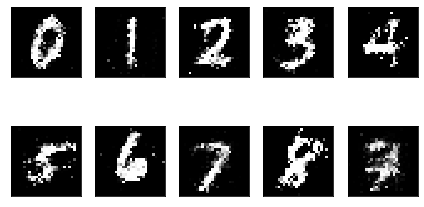

epoch = 32/100, d_loss=0.609, g_loss=0.959.609, g_loss=0.959
epoch = 33/100, d_loss=0.663, g_loss=0.969.663, g_loss=0.969
epoch = 34/100, d_loss=0.610, g_loss=0.927.610, g_loss=0.927
epoch = 35/100, d_loss=0.608, g_loss=0.975.608, g_loss=0.975
epoch = 36/100, d_loss=0.693, g_loss=0.980.693, g_loss=0.980
epoch = 37/100, d_loss=0.659, g_loss=0.927.659, g_loss=0.927
epoch = 38/100, d_loss=0.618, g_loss=0.900.618, g_loss=0.900
epoch = 39/100, d_loss=0.634, g_loss=0.929.634, g_loss=0.929
epoch = 40/100, d_loss=0.608, g_loss=0.951.608, g_loss=0.951
epoch = 41/100, d_loss=0.666, g_loss=0.868.666, g_loss=0.868


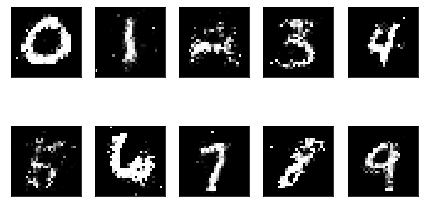

epoch = 42/100, d_loss=0.610, g_loss=0.879.610, g_loss=0.879
epoch = 43/100, d_loss=0.664, g_loss=0.873.664, g_loss=0.873
epoch = 44/100, d_loss=0.659, g_loss=0.908.659, g_loss=0.908
epoch = 45/100, d_loss=0.623, g_loss=0.951.623, g_loss=0.951
epoch = 46/100, d_loss=0.644, g_loss=0.983.644, g_loss=0.983
epoch = 47/100, d_loss=0.661, g_loss=0.908.661, g_loss=0.908
epoch = 48/100, d_loss=0.679, g_loss=0.880.679, g_loss=0.880
epoch = 49/100, d_loss=0.653, g_loss=0.890.653, g_loss=0.890
epoch = 50/100, d_loss=0.661, g_loss=0.900.661, g_loss=0.900
epoch = 51/100, d_loss=0.629, g_loss=0.920.629, g_loss=0.920


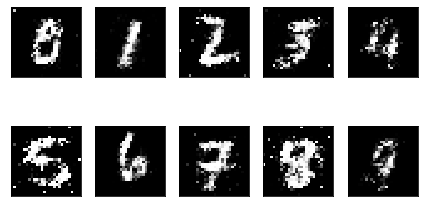

epoch = 52/100, d_loss=0.652, g_loss=0.900.652, g_loss=0.900
epoch = 53/100, d_loss=0.616, g_loss=0.893.616, g_loss=0.893
epoch = 54/100, d_loss=0.644, g_loss=0.887.644, g_loss=0.887
epoch = 55/100, d_loss=0.615, g_loss=0.989.615, g_loss=0.989
epoch = 56/100, d_loss=0.622, g_loss=0.948.622, g_loss=0.948
epoch = 57/100, d_loss=0.663, g_loss=0.891.663, g_loss=0.891
epoch = 58/100, d_loss=0.641, g_loss=0.962.641, g_loss=0.962
epoch = 59/100, d_loss=0.585, g_loss=0.884.585, g_loss=0.884
epoch = 60/100, d_loss=0.635, g_loss=0.915.635, g_loss=0.915
epoch = 61/100, d_loss=0.628, g_loss=1.011.628, g_loss=1.011


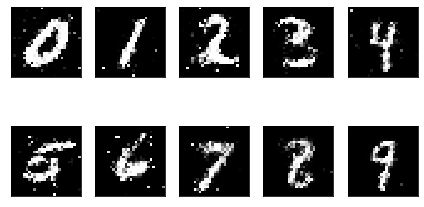

epoch = 62/100, d_loss=0.653, g_loss=0.882.653, g_loss=0.882
epoch = 63/100, d_loss=0.653, g_loss=0.875.653, g_loss=0.875
epoch = 64/100, d_loss=0.629, g_loss=0.870.629, g_loss=0.870
epoch = 65/100, d_loss=0.617, g_loss=0.913.617, g_loss=0.913
epoch = 66/100, d_loss=0.594, g_loss=0.890.594, g_loss=0.890
epoch = 67/100, d_loss=0.625, g_loss=0.903.625, g_loss=0.903
epoch = 68/100, d_loss=0.636, g_loss=0.951.636, g_loss=0.951
epoch = 69/100, d_loss=0.681, g_loss=0.906.681, g_loss=0.906
epoch = 70/100, d_loss=0.653, g_loss=0.926.653, g_loss=0.926
epoch = 71/100, d_loss=0.650, g_loss=0.889.650, g_loss=0.889


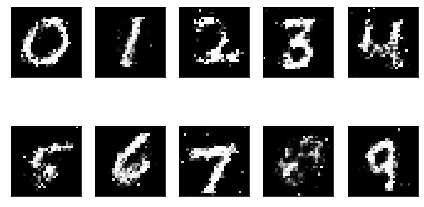

epoch = 72/100, d_loss=0.641, g_loss=0.894.641, g_loss=0.894
epoch = 73/100, d_loss=0.640, g_loss=0.927.640, g_loss=0.927
epoch = 74/100, d_loss=0.646, g_loss=0.884.646, g_loss=0.884
epoch = 75/100, d_loss=0.620, g_loss=0.894.620, g_loss=0.894
epoch = 76/100, d_loss=0.636, g_loss=0.901.636, g_loss=0.901
epoch = 77/100, d_loss=0.679, g_loss=0.972.679, g_loss=0.972
epoch = 78/100, d_loss=0.658, g_loss=0.899.658, g_loss=0.899
epoch = 79/100, d_loss=0.666, g_loss=0.889.666, g_loss=0.889
epoch = 80/100, d_loss=0.635, g_loss=0.938.635, g_loss=0.938
epoch = 81/100, d_loss=0.629, g_loss=0.906.629, g_loss=0.906


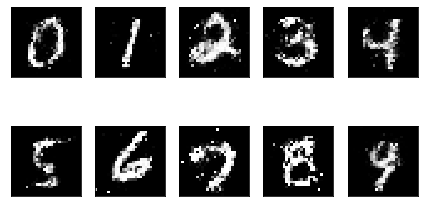

epoch = 82/100, d_loss=0.645, g_loss=0.883.645, g_loss=0.883
epoch = 83/100, d_loss=0.638, g_loss=0.909.638, g_loss=0.909
epoch = 84/100, d_loss=0.654, g_loss=0.902.654, g_loss=0.902
epoch = 85/100, d_loss=0.654, g_loss=0.936.654, g_loss=0.936
epoch = 86/100, d_loss=0.656, g_loss=0.885.656, g_loss=0.885
epoch = 87/100, d_loss=0.652, g_loss=0.899.652, g_loss=0.899
epoch = 88/100, d_loss=0.648, g_loss=0.957.648, g_loss=0.957
epoch = 89/100, d_loss=0.609, g_loss=0.861.609, g_loss=0.861
epoch = 90/100, d_loss=0.641, g_loss=0.868.641, g_loss=0.868
epoch = 91/100, d_loss=0.643, g_loss=0.920.643, g_loss=0.920


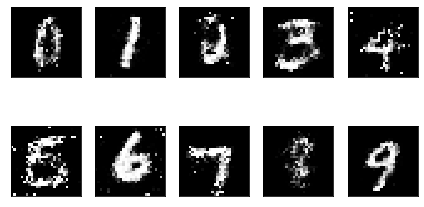

epoch = 92/100, d_loss=0.643, g_loss=0.941.643, g_loss=0.941
epoch = 93/100, d_loss=0.626, g_loss=0.897.626, g_loss=0.897


In [ ]:
start = time.process_time()
epochs = 100
batch_size = 64
smooth = 0.1

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss = []
d_g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):
        
        # Train Discriminator weights
        discriminator.trainable = True
        
        # Real samples
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        real_labels = y_train[i*batch_size:(i+1)*batch_size].reshape(-1, 1)
        
        d_loss_real = discriminator.train_on_batch(x=[X_batch, real_labels], y=real * (1 - smooth))
        
        # Fake Samples
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        random_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)
        X_fake = generator.predict_on_batch([z, random_labels])
        
        d_loss_fake = discriminator.train_on_batch(x=[X_fake, random_labels], y=fake)
         
        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        
        # Train Generator weights
        discriminator.trainable = False
        
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        random_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)
        d_g_loss_batch = d_g.train_on_batch(x=[z, random_labels], y=real)
   
        print(f'epoch = {e + 1}/{epochs}, batch = {i}/{len(X_train)//batch_size}, d_loss={d_loss_batch:.3f}, g_loss={d_g_loss_batch[0]:.3f}',
             end="\r")
        
    d_loss.append(d_loss_batch)
    d_g_loss.append(d_g_loss_batch[0])
    print(f'epoch = {e + 1}/{epochs}, d_loss={d_loss[-1]:.3f}, g_loss={d_g_loss[-1]:.3f}')

    if e % 10 == 0:
        samples = 10
        z = np.random.normal(loc=0, scale=1, size=(samples, latent_dim))
        labels = np.arange(0, 10).reshape(-1, 1)
        
        x_fake = generator.predict([z, labels])

        for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()
stop = time.process_time()

In [3]:
hours = (stop-start)//3600
minutes = ((stop-start)-hours*3600)//60
seconds = (start-stop)-minutes*60
time_taken = f'{hours}hours {minutes}min {seconds}sec'
time_taken #trained in kaggle notebooks and took this much time(58 minutes)

## Visualizing Loss

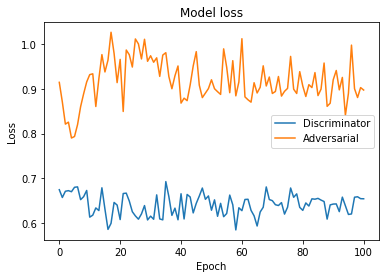

In [20]:
# plotting the metrics
plt.plot(d_loss)
plt.plot(d_g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()

In [21]:
d_g.save("mnist_GANs.h5")